## Imports

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb
import numpy as np
from torchvision import transforms
from custom_dataset import VideoFrameDataset, ImglistToTensor
from mmcv_csn import ResNet3dCSN
from i3d_head import I3DHead

wandb.init(entity="cares", project="autoencoder-mnist", group="sampleframes", name="123")

/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
wandb: Currently logged in as: sttaseen (cares). Use `wandb login --relogin` to force relogin


## Device Agnostic Code

In [2]:
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Custom Dataset


In [3]:
data_root = os.path.join(os.getcwd(), 'data/signmnist') 
ann_file_train = os.path.join(os.getcwd(), 'data/signmnist/annotation_train.txt') 
ann_file_test = os.path.join(os.getcwd(), 'data/signmnist/annotation_test.txt')
work_dir = 'work_dirs/signmnist/sampleframes/'
batch_size = 8

os.makedirs(work_dir, exist_ok=True)


# Setting up data augments
train_pipeline = transforms.Compose([
        ImglistToTensor(),
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((256, 256), scale=(0.6, 1.0)),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]),
    ])

test_pipeline = transforms.Compose([
        ImglistToTensor(), # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize((256, 256)),  # image batch, resize smaller edge to 256
        transforms.CenterCrop((224, 224)),  # image batch, center crop to square 224x224
        transforms.Normalize(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]),
    ])

# Setting up datasets
train_dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=ann_file_train,
    clip_len=32,
    frame_interval=2,
    num_clips=1,
    imagefile_template='img_{:05d}.jpg',
    transform=train_pipeline,
    test_mode=False
)

test_dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=ann_file_test,
    clip_len=32,
    frame_interval=2,
    num_clips=1,
    imagefile_template='img_{:05d}.jpg',
    transform=test_pipeline,
    test_mode=True
)

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

# Testing
dataiter = iter(train_loader)
get = next(dataiter)
reshape = get[0].permute(0,2,1,3,4)
video = iter(reshape[0][0])

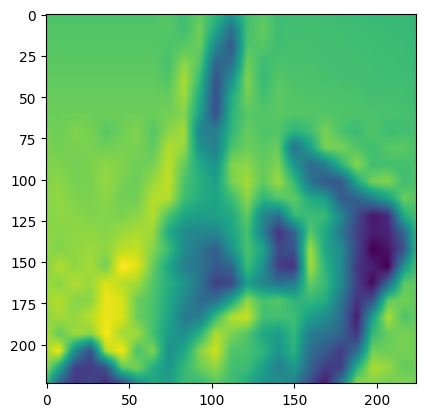

In [4]:
plt.imshow(next(video))

## Set up model, loss and optimiser

In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        code = self.encoder(x)[4]
        return self.decoder(code)

In [6]:
# Create a CSN model
encoder = ResNet3dCSN(
    pretrained2d=False,
    pretrained=None,
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)
# encoder.init_weights()

In [7]:
decoder = I3DHead(num_classes=2000,
                 in_channels=2048,
                 spatial_type='avg',
                 dropout_ratio=0.5,
                 init_std=0.01)

decoder.init_weights()

In [9]:
model = EncoderDecoder(encoder, decoder)

# Transfer model to device
model.to(device)

EncoderDecoder(
  (encoder): ResNet3dCSN(
    (conv1): ConvModule(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
    (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (pool2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): CSNBottleneck3d(
        (conv1): ConvModule(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (activate): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): ConvModule(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=64, bi

In [21]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

# Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=0)

# Specify learning rate scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,150])

# Setup wandb
wandb.watch(model, log_freq=10)

[]

In [ ]:
# checkpoints = torch.load(work_dir+'latest.pth')
# model.load_state_dict(checkpoints)

In [17]:
def top_k_accuracy(scores, labels, topk=(1, )):
    """Calculate top k accuracy score.
    Args:
        scores (list[np.ndarray]): Prediction scores for each class.
        labels (list[int]): Ground truth labels.
        topk (tuple[int]): K value for top_k_accuracy. Default: (1, ).
    Returns:
        list[float]: Top k accuracy score for each k.
    """
    res = np.zeros(len(topk))
    labels = np.array(labels)[:, np.newaxis]
    for i, k in enumerate(topk):
        max_k_preds = np.argsort(scores, axis=1)[:, -k:][:, ::-1]
        match_array = np.logical_or.reduce(max_k_preds == labels, axis=1)
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res[i] = topk_acc_score

    return res

In [18]:
def train_one_epoch(epoch_index, interval=5):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (images, targets) in enumerate(train_loader):
        # Every data instance is an input + label pair
        images, targets = images.to(device).permute(0,2,1,3,4), targets.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(images)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, targets)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=40, norm_type=2.0)

        # Adjust learning weights
        optimizer.step()
        scheduler.step()

        # Gather data and report
        running_loss += loss.item()
        if i % interval == interval-1:
            last_loss = running_loss / interval # loss per batch     
            print(f'Epoch [{epoch_index}][{i+1}/{len(train_loader)}], lr: {scheduler.get_last_lr()[0]:.5e}, loss: {last_loss:.5}')
            running_loss = 0.

    return last_loss, scheduler.get_last_lr()[0]

In [19]:
def validate():
    running_vloss = 0.0
    running_vacc = np.zeros(2)
    
    print('Evaluating top_k_accuracy...')
    
    with torch.inference_mode():   
        for i, (vimages, vtargets) in enumerate(test_loader):
            vimages, vtargets = vimages.to(device), vtargets.to(device)
            
            voutputs = model(vimages.permute(0,2,1,3,4))
            
            vloss = loss_fn(voutputs, vtargets)
            running_vloss += vloss

            running_vacc += top_k_accuracy(voutputs.detach().cpu().numpy(), vtargets.detach().cpu().numpy(), topk=(1,5))

    avg_vloss = running_vloss / (i + 1)

    acc = running_vacc/len(test_loader)
    top1_acc = acc[0].item()
    top5_acc = acc[1].item()
    
    return (avg_vloss, top1_acc, top5_acc)

In [ ]:
epochs = 150

best_vloss = 1_000_000.

for epoch in range(epochs):
    
    # Turn on gradient tracking and do a forward pass
    model.train(True)
    avg_loss, learning_rate = train_one_epoch(epoch+1)
    
    # Turn off  gradients for reporting
    model.train(False)
    
    avg_vloss, top1_acc, top5_acc = validate()
    
    print(f'top1_acc: {top1_acc:.4}, top5_acc: {top5_acc:.4}, train_loss: {avg_loss:.5}, val_loss: {avg_vloss:.5}')
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = work_dir + f'epoch_{epoch+1}'
        print(f'Saving checkpoint at {epoch+1} epochs...')
        torch.save(model.state_dict(), model_path)
        
    # Track wandb
    wandb.log({'train/loss': avg_loss,
               'train/learning_rate': learning_rate,
             'val/loss': avg_vloss,
             'val/top1_accuracy': top1_acc,
             'val/top5_accuracy': top5_acc})

Epoch [1][5/3432], lr: 1.00000e-05, loss: 7.577
Epoch [1][10/3432], lr: 1.00000e-05, loss: 7.5857
Epoch [1][15/3432], lr: 1.00000e-05, loss: 7.5903
Epoch [1][20/3432], lr: 1.00000e-05, loss: 7.5788
Epoch [1][25/3432], lr: 1.00000e-05, loss: 7.5745
Epoch [1][30/3432], lr: 1.00000e-05, loss: 7.5918
Epoch [1][35/3432], lr: 1.00000e-05, loss: 7.5972
Epoch [1][40/3432], lr: 1.00000e-05, loss: 7.5726


In [38]:
dataiter = iter(test_loader)

In [39]:
video, target = next(dataiter)

In [40]:
video.shape

torch.Size([1, 32, 3, 224, 224])

In [41]:
target

tensor([39])

In [42]:
with torch.no_grad():  
    video, target = next(dataiter)
    vimages, vtargets = video.to(device), target.to(device)

    voutputs = model(vimages.permute(0,2,1,3,4))
    
voutputs.argmax(), vtargets

(tensor(9, device='cuda:0'), tensor([89], device='cuda:0'))

In [43]:
voutputs[0][8:14]

tensor([1.0868, 1.4663, 0.9650, 1.0108, 0.9702, 0.8265], device='cuda:0')